In [25]:

from __future__ import annotations

import json
import hashlib
from dataclasses import dataclass
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Reuse your project color map if available
try:
    from src.game.constants import COLOR_MAP
except Exception:
    COLOR_MAP = {
        "R": (0.85, 0.25, 0.25),
        "G": (0.25, 0.75, 0.35),
        "B": (0.30, 0.45, 0.90),
        "Y": (0.95, 0.85, 0.30),
        "BK": (0.0, 0.0, 0.0),
        "LG": (0.92, 0.92, 0.92),
        "W": (1.0, 1.0, 1.0),
    }


@dataclass(frozen=True)
class RunRoute:
    model_pair: str
    log_path: Path
    grid: list[list[str]]
    route_red: list[tuple[int, int]]   # player 0
    route_blue: list[tuple[int, int]]  # player 1


def _parse_coord(x: Any) -> tuple[int, int]:
    if isinstance(x, (list, tuple)) and len(x) == 2:
        return int(x[0]), int(x[1])
    if isinstance(x, dict) and "r" in x and "c" in x:
        return int(x["r"]), int(x["c"])
    if isinstance(x, str) and "," in x:
        r, c = x.split(",", 1)
        return int(r.strip()), int(c.strip())
    raise ValueError(f"Unrecognized coordinate format: {x!r}")


def _extract_routes_from_event_log(data: dict) -> tuple[list[tuple[int, int]], list[tuple[int, int]]]:
    players = (((data.get("game") or {}).get("final_state") or {}).get("players") or {})
    p0 = players.get("0") or {}
    p1 = players.get("1") or {}

    r0 = p0.get("route") or []
    r1 = p1.get("route") or []
    return ([_parse_coord(x) for x in r0], [_parse_coord(x) for x in r1])


def _extract_grid_from_event_log(data: dict) -> list[list[str]]:
    game = data.get("game", {})
    for path in (
        ("config", "grid"),
        ("grid", "tiles"),
        ("grid", "tile_colors"),
        ("initial_state", "grid"),
        ("final_state", "grid"),
    ):
        cur: Any = game
        ok = True
        for k in path:
            if isinstance(cur, dict) and k in cur:
                cur = cur[k]
            else:
                ok = False
                break
        if ok and isinstance(cur, list) and cur and isinstance(cur[0], list):
            return cur
    raise KeyError("Could not find grid in event log JSON (tried several paths).")


def _extract_grid_from_metadata(sibling_metadata_json: Path) -> list[list[str]]:
    with sibling_metadata_json.open("r") as f:
        md = json.load(f)
    grid = md.get("grid")
    if not (isinstance(grid, list) and grid and isinstance(grid[0], list)):
        raise KeyError(f"metadata.json does not contain a valid 'grid': {sibling_metadata_json}")
    return grid


def find_no_contract_no_p4p_grid_runs(
    base_dir: str | Path,
    bucket_dir: str,
    grid_id: int,
    config_dir: str = "ctx1_fog00_p4pfalse_contract_none_selfish11",
) -> list[Path]:
    base_dir = Path(base_dir)
    grid_dir = f"grid_{grid_id:03d}"
    pattern = f"*/{bucket_dir}/{grid_dir}/{config_dir}/**/event_log_grid_{grid_id}_*.json"
    return sorted(base_dir.glob(pattern))


def load_run_routes(log_path: Path) -> RunRoute:
    with log_path.open("r") as f:
        data = json.load(f)

    try:
        model_pair = log_path.parts[log_path.parts.index("reduced_config_runs") + 1]
    except Exception:
        model_pair = "UNKNOWN"

    metadata_path = log_path.parent / "metadata.json"
    if metadata_path.exists():
        grid = _extract_grid_from_metadata(metadata_path)
    else:
        grid = _extract_grid_from_event_log(data)

    route_red, route_blue = _extract_routes_from_event_log(data)

    return RunRoute(
        model_pair=model_pair,
        log_path=log_path,
        grid=grid,
        route_red=route_red,
        route_blue=route_blue,
    )


def _normalize_rgba(x):
    if isinstance(x, str):
        return x
    if isinstance(x, (tuple, list)) and len(x) in (3, 4):
        vals = [float(v) for v in x]
        if any(v > 1.0 for v in vals):
            vals = [v / 255.0 for v in vals]
        vals = [min(1.0, max(0.0, v)) for v in vals]
        return tuple(vals)
    return x


def _draw_grid(ax, grid: list[list[str]]):
    n_rows = len(grid)
    n_cols = len(grid[0]) if n_rows else 0

    for r in range(n_rows):
        for c in range(n_cols):
            col = grid[r][c]
            face_raw = COLOR_MAP.get(col, COLOR_MAP.get("LG", (0.9, 0.9, 0.9)))
            face = _normalize_rgba(face_raw)
            ax.add_patch(Rectangle((c, r), 1, 1, facecolor=face, edgecolor="black", linewidth=0.8))

    ax.set_xlim(0, n_cols)
    ax.set_ylim(n_rows, 0)
    ax.set_aspect("equal")

    ax.set_xticks([i + 0.5 for i in range(n_cols)])
    ax.set_yticks([i + 0.5 for i in range(n_rows)])
    ax.set_xticklabels([str(i) for i in range(n_cols)])
    ax.set_yticklabels([str(i) for i in range(n_rows)])
    ax.tick_params(length=0)
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")


def plot_routes_overlay(
    runs: list[RunRoute],
    out_path: str | Path,
    title: str | None = None,
    route_alpha: float = 0.28,     # fainter route
    endpoint_alpha: float = 0.95,  # stronger endpoints
    route_marker_size: int = 34,
    start_marker_size: int = 150,
    end_marker_size: int = 150,
    jitter: float = 0.72,          # MUCH more jitter (tile units)
    dotted: bool = True,
    show: bool = True,             # print/show image in notebook
):
    # deterministic jitter per RUN (log file), so multiple repeats of same model-pair separate
    def _stable_unit_float(key: str) -> float:
        # returns float in [0, 1)
        h = hashlib.md5(key.encode("utf-8")).hexdigest()  # stable across runs
        return int(h[:8], 16) / 16**8

    def _jitter_for_run(log_path: Path) -> tuple[float, float]:
        key = str(log_path)
        u1 = _stable_unit_float(key + "|x")
        u2 = _stable_unit_float(key + "|y")
        # map to [-jitter, +jitter]
        jx = (u1 - 0.5) * 2 * jitter
        jy = (u2 - 0.5) * 2 * jitter
        return jx, jy
    
    if not runs:
        raise ValueError("No runs provided.")

    grid = runs[0].grid

    model_pairs = sorted({r.model_pair for r in runs})
    markers = ["s", "^", "D", "P", "X", "v", "<", ">", "H", "*", "o"]
    if len(model_pairs) > len(markers):
        raise ValueError(f"Need more marker shapes: {len(model_pairs)} model pairs > {len(markers)} markers.")
    mp_to_marker = {mp: markers[i] for i, mp in enumerate(model_pairs)}

    # deterministic jitter per model pair
    def _jitter_for(mp: str) -> tuple[float, float]:
        h = abs(hash(mp))
        jx = ((h % 10_000) / 10_000.0 - 0.5) * 2 * jitter
        jy = (((h // 10_000) % 10_000) / 10_000.0 - 0.5) * 2 * jitter
        return jx, jy

    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    _draw_grid(ax, grid)

    def _to_xy(route: list[tuple[int, int]], jx: float, jy: float):
        xs = [c + 0.5 + jx for (r, c) in route]
        ys = [r + 0.5 + jy for (r, c) in route]
        return xs, ys

    def draw_route(route: list[tuple[int, int]], color: str, marker: str, jx: float, jy: float):
        if not route:
            return

        xs, ys = _to_xy(route, jx, jy)

        # faint dotted path (line) + markers in the same shape
        if dotted and len(xs) >= 2:
            ax.plot(
                xs,
                ys,
                color=color,
                alpha=route_alpha,
                linewidth=1.6,
                linestyle=(0, (1.0, 3.0)),  # dotted-ish
                zorder=2,
            )

        ax.scatter(
            xs,
            ys,
            s=route_marker_size,
            color=color,
            marker=marker,
            alpha=route_alpha,
            linewidths=0.25,
            edgecolors="k",
            zorder=3,
        )

        # start (bigger)
        ax.scatter(
            [xs[0]],
            [ys[0]],
            s=start_marker_size,
            color=color,
            marker=marker,
            alpha=endpoint_alpha,
            linewidths=1.2,
            edgecolors="k",
            zorder=5,
        )

        # end (bigger)
        ax.scatter(
            [xs[-1]],
            [ys[-1]],
            s=end_marker_size,
            color=color,
            marker=marker,
            alpha=endpoint_alpha,
            linewidths=1.2,
            edgecolors="k",
            zorder=5,
        )

    for rr in runs:
        marker = mp_to_marker[rr.model_pair]
        jx, jy = _jitter_for_run(rr.log_path)
        draw_route(rr.route_red, color="red", marker=marker, jx=jx, jy=jy)
        draw_route(rr.route_blue, color="blue", marker=marker, jx=jx, jy=jy)

    # legend
    from matplotlib.lines import Line2D
    handles = [
        Line2D([0], [0], marker=mp_to_marker[mp], linestyle="None", color="k",
               markerfacecolor="0.7", markeredgecolor="k", markersize=9, label=mp)
        for mp in model_pairs
    ]
    handles += [
        Line2D([0], [0], marker="o", linestyle="None", color="red", markerfacecolor="red", markersize=9, label="P-Red (player 0)"),
        Line2D([0], [0], marker="o", linestyle="None", color="blue", markerfacecolor="blue", markersize=9, label="P-Blue (player 1)"),
    ]
    ax.legend(handles=handles, title="Model pair / Player", bbox_to_anchor=(1.02, 1), loc="upper left")

    if title:
        ax.set_title(title)

    fig.tight_layout()

    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=250)

    if show:
        plt.show()
    else:
        plt.close(fig)


def make_overlay_for_grid(
    grid_id: int,
    bucket_dir: str = "Mutual_Dependency",
    base_dir: str | Path = "public_logs/reduced_config_runs",
    config_dir: str = "ctx1_fog00_p4pfalse_contract_none_selfish11",
    out_path: str | Path | None = None,
    jitter: float = 0.22,
):
    log_paths = find_no_contract_no_p4p_grid_runs(
        base_dir=base_dir,
        bucket_dir=bucket_dir,
        grid_id=grid_id,
        config_dir=config_dir,
    )
    print(f"Found {len(log_paths)} logs for grid {grid_id}")

    runs = [load_run_routes(p) for p in log_paths]
    if out_path is None:
        out_path = Path(f"analysis/figures/routes_grid_{grid_id:03d}_no_contract_no_p4p_overlay.png")

    plot_routes_overlay(
        runs,
        out_path=out_path,
        title=f"Grid {grid_id:03d} ({bucket_dir}) — No Contract, No P4P (overlay)",
        jitter=jitter,
        show=True,
    )
    print(f"Wrote {out_path}")


def main(grid_id: int = 84):
    make_overlay_for_grid(grid_id=grid_id, bucket_dir="Mutual_Dependency")


Found 7 logs for grid 84


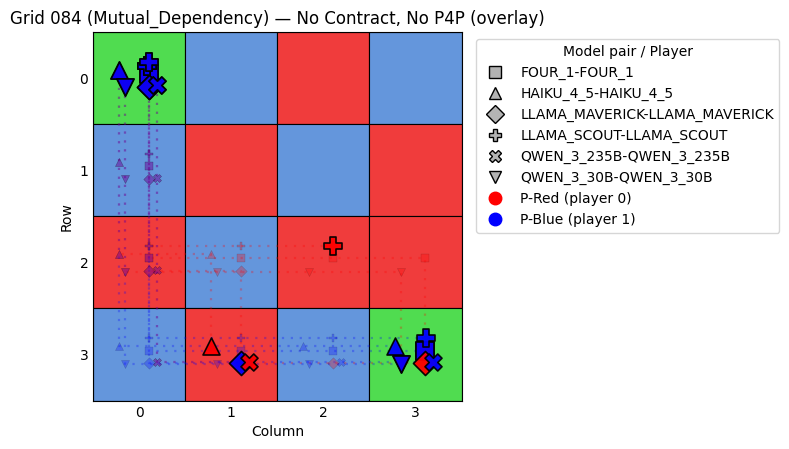

Wrote analysis/figures/routes_grid_084_no_contract_no_p4p_overlay.png


In [26]:
main()

Found 10 logs for grid 83


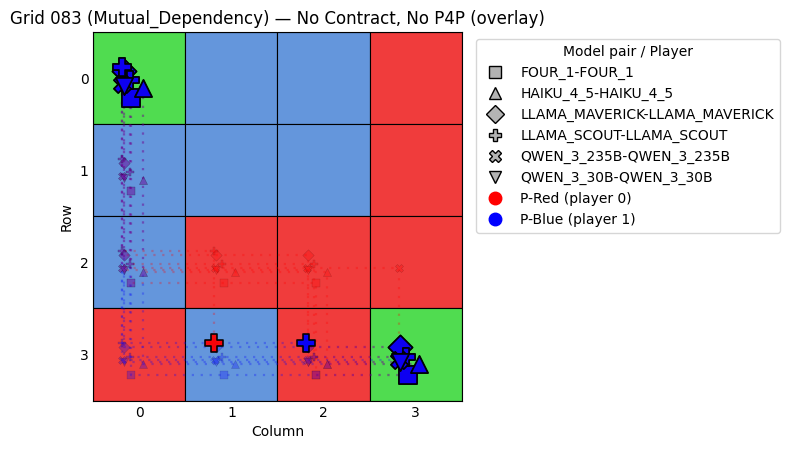

Wrote analysis/figures/routes_grid_083_no_contract_no_p4p_overlay.png


In [27]:
main(grid_id=83)